# VGGIsh Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender

The dataset is highly unbalanced, resources for an unbiased estimate have been implemented.

In [89]:
import optuna
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop, AdamW
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from focal_loss import SparseCategoricalFocalLoss
import shap
from keras.regularizers import l1, l2, L1L2

In [90]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


## Define Functions

In [91]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [92]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [93]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [94]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "multi-seed-val-D13.txt" 

In [95]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

# RANDOM SEED 1

## Prepare Data

In [96]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64


In [97]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [98]:
tf.keras.backend.clear_session()

## Run Setup

In [99]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
002B    32
047A    28
057A    27
074A    25
020A    23
067A    19
000B    19
029A    17
019A    17
097A    16
101A    15
106A    14
059A    14
042A    14
097B    14
028A    13
111A    13
002A    13
116A    12
051A    12
039A    12
036A    11
068A    11
063A    11
005A    10
071A    10
040A    10
014B    10
051B     9
033A     9
065A     9
022A     9
072A     9
095A     8
010A     8
013B     8
099A     7
031A     7
027A     7
050A     7
109A     6
023A     6
007A     6
108A     6
037A     6
075A     5
021A     5
023B     5
025C     5
070A     5
034A     5
044A     5
026A     4
035A     4
105A     4
052A     4
003A     4
062A     4
012A     3
064A     3
006A     3
113A     3
014A     3
061A     2
018A     2
038A     2
054A     2
087A     2
025B     2
011A     2
102A     2
043A     1
090A     1
100A     1
115A     1
004A     1
019B     1
088A     1
049A     1
048A     1
066A     1
096A     1
026C     1
041A     1
026B     1


Epoch 1/1500
23/23 [==============================] - 0s 1ms/step - loss: 1.1408 - accuracy: 0.4686
Epoch 2/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.8076 - accuracy: 0.6053
Epoch 3/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.7571 - accuracy: 0.6151
Epoch 4/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.6832 - accuracy: 0.6430
Epoch 5/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.6179
Epoch 6/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.6328 - accuracy: 0.6569
Epoch 7/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.6318 - accuracy: 0.6667
Epoch 8/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.5894 - accuracy: 0.6834
Epoch 9/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.5751 - accuracy: 0.6960
Epoch 10/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.5765 - accuracy: 0.7127

Final Test Results - Loss: 0.9139342308044434, Accuracy: 0.7090908885002136, Precision: 0.7442328042328041, Recall: 0.7145833333333332, F1 Score: 0.7263518778245285
Confusion Matrix:
 [[123   0  37]
 [  1   7   0]
 [ 26   0  26]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
103A    33
057A    27
055A    20
000B    19
029A    17
101A    15
001A    14
106A    14
042A    14
028A    13
111A    13
039A    12
068A    11
063A    11
036A    11
025A    11
005A    10
016A    10
040A    10
014B    10
071A    10
051B     9
022A     9
065A     9
045A     9
015A     9
010A     8
095A     8
094A     8
013B     8
031A     7
117A     7
053A     6
108A     6
008A     6
109A     6
007A     6
037A     6
070A     5
021A     5
044A     5
023B     5
035A     4
026A     4
105A     4
062A     4
009A     4
104A     4
058A     3
064A     3
014A     3
060A     3
056A     3
113A     3
025B     2
011A     2
061A     2
102A     2
054A     2
093A     2
038A     2
087A     2
032A     2
069A     2
0

Age group distribution: Counter({0: 498, 2: 165, 1: 116})
Epoch 1/1500
25/25 [==============================] - 0s 1ms/step - loss: 1.0232 - accuracy: 0.4929
Epoch 2/1500
25/25 [==============================] - 0s 1ms/step - loss: 0.8445 - accuracy: 0.5083
Epoch 3/1500
25/25 [==============================] - 0s 1ms/step - loss: 0.7387 - accuracy: 0.5777
Epoch 4/1500
25/25 [==============================] - 0s 1ms/step - loss: 0.7595 - accuracy: 0.5751
Epoch 5/1500
25/25 [==============================] - 0s 1ms/step - loss: 0.7139 - accuracy: 0.6059
Epoch 6/1500
25/25 [==============================] - 0s 1ms/step - loss: 0.6840 - accuracy: 0.6123
Epoch 7/1500
25/25 [==============================] - 0s 1ms/step - loss: 0.6291 - accuracy: 0.6406
Epoch 8/1500
25/25 [==============================] - 0s 1ms/step - loss: 0.6118 - accuracy: 0.6611
Epoch 9/1500
25/25 [==============================] - 0s 1ms/step - loss: 0.6142 - accuracy: 0.6701
Epoch 10/1500
25/25 [=====================

## Majority Voting on Total Entries per cat_id 

In [100]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 845, Predictions: 845, Actuals: 845, Gender: 845


In [101]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [102]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.75 (82/110)


In [103]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [104]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, adult, senior, adult, adult, ad...",adult,adult,True
63,057A,"[adult, adult, adult, senior, senior, senior, ...",senior,senior,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
70,064A,"[adult, adult, adult]",adult,adult,True


In [105]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     58
kitten    13
senior    11
Name: Majority_Correct, dtype: int64


In [106]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             58  79.452055
1           kitten           15             13  86.666667
2           senior           22             11  50.000000


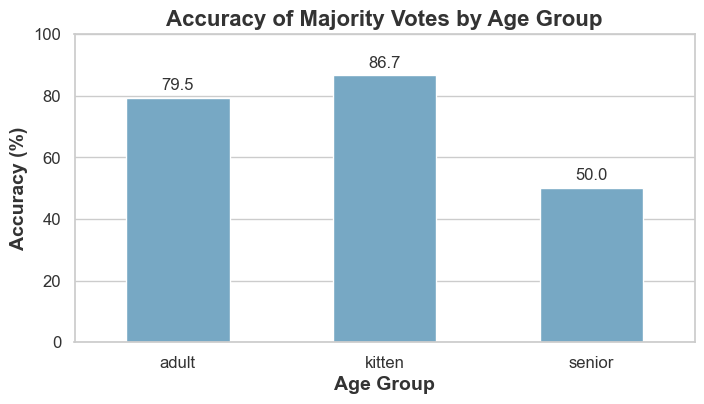

In [107]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [108]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          558            431  77.240143
1           kitten          109             91  83.486239
2           senior          178             96  53.932584


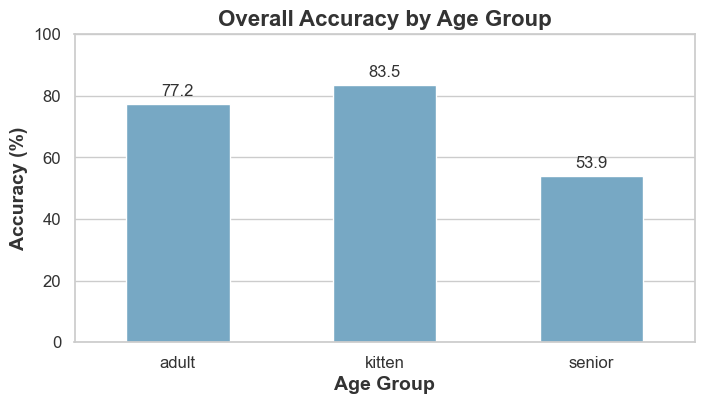

In [109]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [110]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      167     78.40
1          M    337      229     67.95
2          X    295      222     75.25


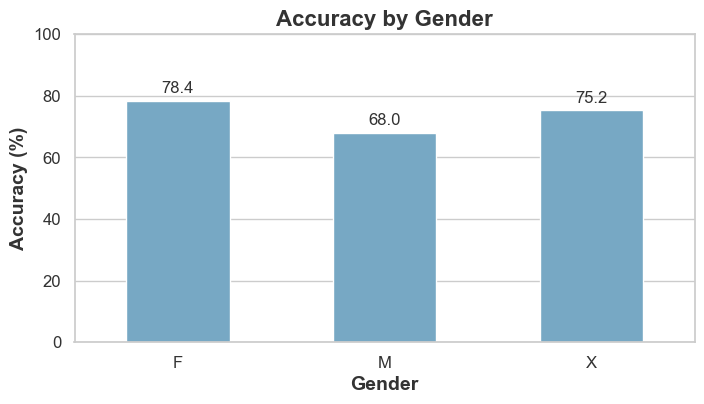

In [111]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# RANDOM SEED 2

In [112]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1]))
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64


In [113]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [114]:
tf.keras.backend.clear_session()

## Run Setup

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
057A    27
020A    23
055A    20
000B    19
067A    19
019A    17
029A    17
106A    14
097B    14
001A    14
059A    14
028A    13
002A    13
039A    12
116A    12
063A    11
025A    11
005A    10
040A    10
016A    10
071A    10
022A     9
051B     9
072A     9
065A     9
045A     9
033A     9
013B     8
094A     8
010A     8
095A     8
027A     7
117A     7
031A     7
109A     6
108A     6
053A     6
008A     6
023A     6
037A     6
007A     6
034A     5
025C     5
070A     5
023B     5
044A     5
075A     5
035A     4
062A     4
026A     4
105A     4
104A     4
052A     4
009A     4
060A     3
012A     3
006A     3
064A     3
058A     3
054A     2
061A     2
087A     2
069A     2
032A     2
011A     2
018A     2
025B     2
093A     2
088A     1
091A     1
100A     1
090A     1
019B     1
115A     1
066A     1
004A     1
048A     1
073A     1
026C     1
076A     1
041A     1
092A     1
049A     1
043A     1
026B     1


No common groups found between train and test sets.
Moved to Training/Validation Set:
{'046A'}
Removed from Training/Validation Set:
{'040A'}
Moved to Test Set:
{'040A'}
Removed from Test Set
{'046A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '002A' '002B' '003A' '004A' '005A' '006A' '007A' '009A'
 '010A' '012A' '013B' '014A' '014B' '015A' '016A' '018A' '019B' '020A'
 '021A' '023A' '023B' '024A' '025A' '025B' '025C' '026A' '026C' '027A'
 '028A' '031A' '032A' '034A' '035A' '036A' '038A' '039A' '041A' '042A'
 '044A' '046A' '047A' '048A' '049A' '050A' '051A' '052A' '053A' '054A'
 '055A' '056A' '057A' '058A' '059A' '062A' '066A' '068A' '069A' '070A'
 '071A' '073A' '074A' '088A' '090A' '092A' '094A' '096A' '097A' '097B'
 '099A' '101A' '102A' '103A' '104A' '106A' '108A' '110A' '111A' '113A'
 '115A' '116A' '117A']
AFTER SWAP - Unique Test Group IDs:
['001A' '008A' '011A' '019A' '022A' '026B' '029A' '033A' '037A' '040A'
 '043A' '045A' '051B' '060A' '061A' '063A' '064A' 

Confusion Matrix:
 [[96 20 39]
 [ 3 23  0]
 [ 5  0 10]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
055A    20
067A    19
019A    17
029A    17
097A    16
101A    15
001A    14
042A    14
097B    14
111A    13
039A    12
051A    12
036A    11
068A    11
063A    11
040A    10
014B    10
022A     9
072A     9
065A     9
033A     9
051B     9
045A     9
015A     9
094A     8
095A     8
117A     7
050A     7
099A     7
027A     7
031A     7
008A     6
109A     6
053A     6
037A     6
108A     6
023A     6
023B     5
075A     5
021A     5
105A     4
026A     4
062A     4
035A     4
052A     4
003A     4
056A     3
113A     3
064A     3
014A     3
060A     3
012A     3
058A     3
061A     2
011A     2
102A     2
093A     2
038A     2
087A     2
069A     2
041A     1
019B     1
024A     1
100A     1
110A     1
096A     1
076A     1
088A     1
092A     1
004A     1
043A     1
048A     1
073A     1
091A     1
026B     1

AFTER SWAP - Unique Test Group IDs:
['004A' '012A' '019B' '023A' '023B' '026A' '026C' '027A' '031A' '035A'
 '039A' '040A' '041A' '048A' '052A' '053A' '055A' '057A' '058A' '062A'
 '069A' '073A' '088A' '092A' '094A' '097B' '108A' '117A']
Length of X_train_val:
770
Length of y_train_val:
770
Length of groups_train_val:
770
No common groups found between train and test sets.
Train Age Group Distribution BEFORE SWAP:
adult     466
kitten    159
senior    107
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
adult     122
senior     71
kitten     12
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     504
kitten    159
senior    107
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     84
senior    71
kitten    12
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 504, 1: 159, 2: 107})
Epoch 1/1500
25/25 [==============================] - 0s 1ms/step

## Majority Voting on Total Entries per cat_id 

In [116]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 846, Predictions: 846, Actuals: 846, Gender: 846


In [117]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [118]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.72 (79/110)


In [119]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [120]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, senior, senior, adult, ...",adult,adult,True
45,039A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, senior, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, senior, adult, adult, se...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
70,064A,"[kitten, adult, adult]",adult,adult,True
68,062A,"[adult, adult, adult, adult]",adult,adult,True
62,056A,"[senior, senior, senior]",senior,senior,True


In [121]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     57
kitten    11
senior    11
Name: Majority_Correct, dtype: int64


In [122]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             57  78.082192
1           kitten           15             11  73.333333
2           senior           22             11  50.000000


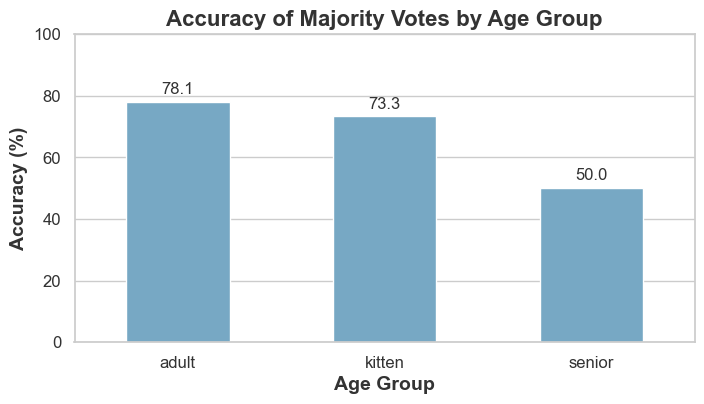

In [123]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [124]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          550            407  74.000000
1           kitten          118             82  69.491525
2           senior          178            102  57.303371


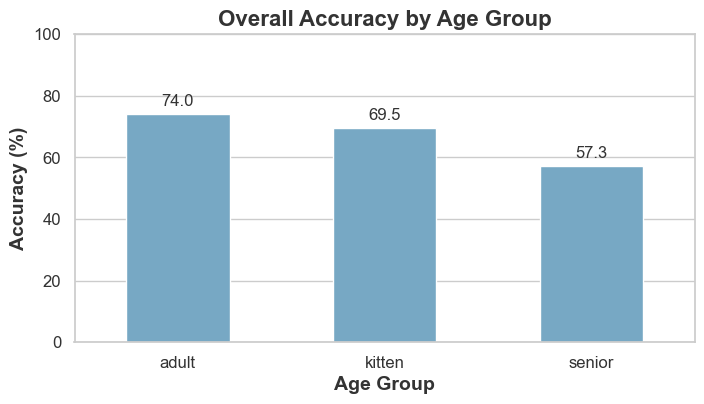

In [125]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [126]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    214      161     75.23
1          M    337      241     71.51
2          X    295      189     64.07


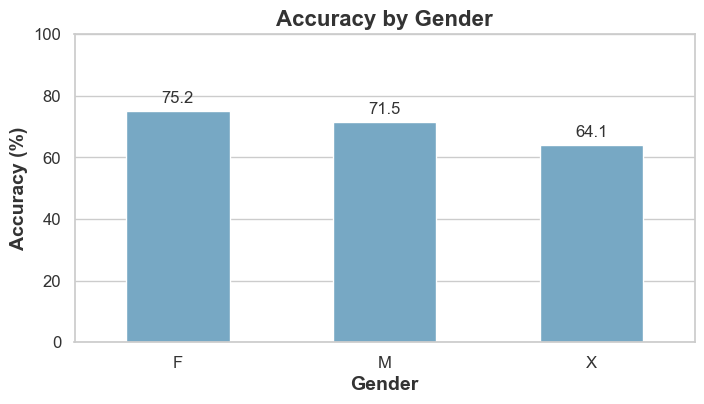

In [127]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# RANDOM SEED 3

In [128]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64


In [129]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [130]:
tf.keras.backend.clear_session()

## Run Setup

In [131]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
020A    23
055A    20
067A    19
097A    16
101A    15
042A    14
106A    14
059A    14
028A    13
002A    13
039A    12
116A    12
063A    11
025A    11
071A    10
016A    10
040A    10
014B    10
033A     9
072A     9
015A     9
022A     9
051B     9
065A     9
095A     8
013B     8
010A     8
094A     8
027A     7
099A     7
031A     7
050A     7
108A     6
109A     6
037A     6
007A     6
008A     6
025C     5
070A     5
021A     5
034A     5
075A     5
023B     5
035A     4
009A     4
026A     4
062A     4
003A     4
012A     3
060A     3
064A     3
006A     3
113A     3
056A     3
058A     3
014A     3
011A     2
061A     2
032A     2
093A     2
025B     2
087A     2
069A     2
073A     1
115A     1
088A     1
100A     1
090A     1
024A     1
019B     1
066A     1
004A     1
048A     1
026C     1
041A     1
092A     1
049A     1
076A     1
096A     1
043A     1
026B     1


Testing Set Age Group Distribution AFTER SWAP:
adult     120
senior     49
kitten     35
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 468, 1: 136, 2: 129})
Epoch 1/1500
23/23 [==============================] - 0s 1ms/step - loss: 1.1275 - accuracy: 0.4843
Epoch 2/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.8452 - accuracy: 0.5539
Epoch 3/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.7914 - accuracy: 0.5634
Epoch 4/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.7242 - accuracy: 0.6003
Epoch 5/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.7028 - accuracy: 0.6248
Epoch 6/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.6744 - accuracy: 0.6426
Epoch 7/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.6136 - accuracy: 0.6617
Epoch 8/1500
23/23 [==============================] - 0s 1ms/step - loss: 0.6419 - 

Majority Vote Accuracy for cat_id for this fold: 0.64 (18/28)
Before appending - Cat IDs: 218, Predictions: 218, Actuals: 218, Gender: 218
After appending - Cat IDs: 422, Predictions: 422, Actuals: 422, Gender: 422
Final Test Results - Loss: 1.0226013660430908, Accuracy: 0.6911764740943909, Precision: 0.6654040404040404, Recall: 0.6880385487528344, F1 Score: 0.6750358422939068
Confusion Matrix:
 [[89  8 23]
 [ 2 32  1]
 [29  0 20]]
outer_fold 3
Train Set Group Distribution:
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
055A    20
000B    19
019A    17
029A    17
101A    15
001A    14
097B    14
042A    14
106A    14
111A    13
028A    13
002A    13
051A    12
116A    12
039A    12
068A    11
025A    11
036A    11
063A    11
014B    10
040A    10
071A    10
005A    10
016A    10
051B     9
033A     9
065A     9
015A     9
045A     9
095A     8
117A     7
099A     7
031A     7
023A     6
007A     6
108A     6
053A     6
021A     5
023B     5
025C     5
070A     5
034A

Majority Vote Accuracy for cat_id for this fold: 0.83 (25/30)
Before appending - Cat IDs: 422, Predictions: 422, Actuals: 422, Gender: 422
After appending - Cat IDs: 612, Predictions: 612, Actuals: 612, Gender: 612
Final Test Results - Loss: 0.47370749711990356, Accuracy: 0.8315789699554443, Precision: 0.834906856261023, Recall: 0.7863868711326338, F1 Score: 0.8074787856559359
Confusion Matrix:
 [[107   2   9]
 [  5  25   0]
 [ 16   0  26]]
outer_fold 4
Train Set Group Distribution:
046A    63
000A    39
002B    32
074A    25
020A    23
000B    19
067A    19
029A    17
019A    17
097A    16
001A    14
097B    14
106A    14
059A    14
042A    14
111A    13
039A    12
051A    12
116A    12
068A    11
036A    11
063A    11
016A    10
005A    10
040A    10
014B    10
071A    10
022A     9
015A     9
065A     9
045A     9
072A     9
051B     9
095A     8
013B     8
010A     8
094A     8
027A     7
050A     7
117A     7
037A     6
053A     6
008A     6
109A     6
023A     6
044A     5
023B  

## Majority Voting on Total Entries per cat_id 

In [132]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 850, Predictions: 850, Actuals: 850, Gender: 850


In [133]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [134]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.72 (79/110)


In [135]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [136]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, kitten, senior, adult, adult, a...",adult,adult,True
45,039A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, senior, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
70,064A,"[adult, adult, adult]",adult,adult,True
68,062A,"[kitten, kitten, adult, adult]",adult,adult,True


In [137]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     58
kitten    13
senior     8
Name: Majority_Correct, dtype: int64


In [138]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             58  79.452055
1           kitten           15             13  86.666667
2           senior           22              8  36.363636


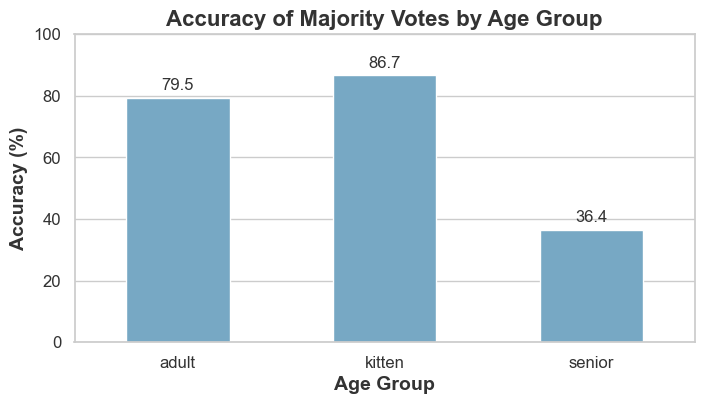

In [139]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [140]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          550            416  75.636364
1           kitten          122            104  85.245902
2           senior          178             80  44.943820


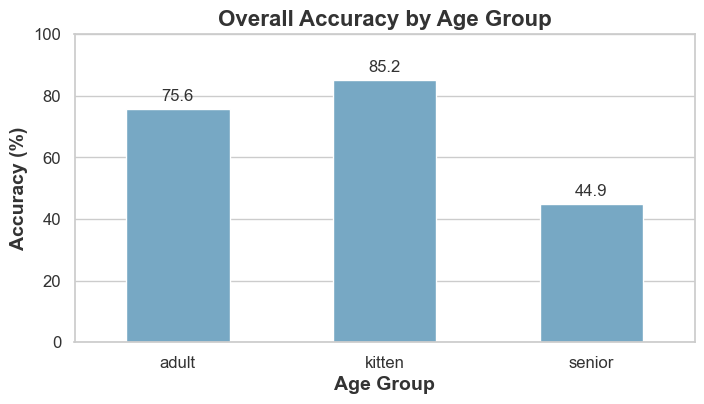

In [141]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')


## Gender Exploration

In [142]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      144     67.61
1          M    338      241     71.30
2          X    299      215     71.91


In [143]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      144     67.61
1          M    338      241     71.30
2          X    299      215     71.91


# RANDOM SEED 4

In [144]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64


In [145]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [146]:
tf.keras.backend.clear_session()

## Run Setup

In [147]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
055A    20
067A    19
000B    19
029A    17
097A    16
059A    14
042A    14
001A    14
097B    14
106A    14
111A    13
028A    13
002A    13
051A    12
116A    12
036A    11
068A    11
025A    11
014B    10
016A    10
040A    10
072A     9
015A     9
051B     9
022A     9
033A     9
045A     9
095A     8
013B     8
117A     7
031A     7
027A     7
007A     6
108A     6
053A     6
109A     6
023A     6
037A     6
075A     5
070A     5
025C     5
021A     5
034A     5
044A     5
023B     5
003A     4
105A     4
035A     4
026A     4
052A     4
062A     4
012A     3
113A     3
058A     3
060A     3
064A     3
006A     3
025B     2
032A     2
093A     2
054A     2
069A     2
087A     2
038A     2
073A     1
004A     1
090A     1
110A     1
115A     1
091A     1
019B     1
066A     1
048A     1
092A     1
026C     1
076A     1
043A     1
041A     1
024A     1


Majority Vote Accuracy for cat_id for this fold: 0.80 (20/25)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 147, Predictions: 147, Actuals: 147, Gender: 147
Final Test Results - Loss: 0.6756552457809448, Accuracy: 0.7755101919174194, Precision: 0.6943574943574943, Recall: 0.8788011695906434, F1 Score: 0.7389857196308306
Confusion Matrix:
 [[89  3 28]
 [ 0  8  0]
 [ 2  0 17]]
outer_fold 2
Train Set Group Distribution:
046A    63
000A    39
103A    33
047A    28
057A    27
074A    25
000B    19
019A    17
097A    16
101A    15
106A    14
042A    14
059A    14
001A    14
028A    13
002A    13
111A    13
116A    12
039A    12
051A    12
063A    11
025A    11
036A    11
040A    10
016A    10
005A    10
071A    10
014B    10
022A     9
065A     9
051B     9
072A     9
010A     8
013B     8
095A     8
094A     8
031A     7
050A     7
117A     7
027A     7
099A     7
008A     6
108A     6
007A     6
023A     6
037A     6
023B     5
070A     5
0

Before appending - Cat IDs: 147, Predictions: 147, Actuals: 147, Gender: 147
After appending - Cat IDs: 355, Predictions: 355, Actuals: 355, Gender: 355
Final Test Results - Loss: 0.6587229371070862, Accuracy: 0.75, Precision: 0.6262272771459122, Recall: 0.8134123909044656, F1 Score: 0.6725893154464583
Confusion Matrix:
 [[121  12  34]
 [  2  15   0]
 [  4   0  20]]
outer_fold 3
Train Set Group Distribution:
002B    32
047A    28
074A    25
020A    23
055A    20
000B    19
067A    19
019A    17
029A    17
097A    16
101A    15
097B    14
059A    14
028A    13
002A    13
039A    12
051A    12
063A    11
036A    11
068A    11
005A    10
016A    10
071A    10
065A     9
045A     9
022A     9
015A     9
033A     9
010A     8
094A     8
050A     7
031A     7
117A     7
099A     7
007A     6
108A     6
109A     6
008A     6
053A     6
075A     5
044A     5
021A     5
025C     5
034A     5
023B     5
009A     4
003A     4
104A     4
062A     4
113A     3
014A     3
056A     3
060A     3
064A 

Majority Vote Accuracy for cat_id for this fold: 0.80 (24/30)
Before appending - Cat IDs: 355, Predictions: 355, Actuals: 355, Gender: 355
After appending - Cat IDs: 608, Predictions: 608, Actuals: 608, Gender: 608
Final Test Results - Loss: 0.792750895023346, Accuracy: 0.731225311756134, Precision: 0.7420235777633571, Recall: 0.7232470127992516, F1 Score: 0.7315805109922757
Confusion Matrix:
 [[102   6  26]
 [ 12  42   0]
 [ 24   0  41]]
outer_fold 4
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
057A    27
020A    23
055A    20
067A    19
019A    17
029A    17
101A    15
097B    14
042A    14
001A    14
106A    14
111A    13
039A    12
116A    12
068A    11
025A    11
063A    11
040A    10
071A    10
014B    10
005A    10
072A     9
065A     9
015A     9
033A     9
051B     9
045A     9
094A     8
010A     8
095A     8
013B     8
050A     7
027A     7
099A     7
053A     6
109A     6
008A     6
037A     6
023A     6
025C     5
070A     5
075A     5
035A    

## Majority Voting on Total Entries per cat_id 

In [148]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 843, Predictions: 843, Actuals: 843, Gender: 843


In [149]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [150]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.79 (87/110)


In [151]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [152]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, kitten, kitten, senior, adult, adult, ...",adult,adult,True
61,055A,"[senior, senior, senior, senior, senior, senio...",senior,senior,True
76,070A,"[adult, adult, senior, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
70,064A,"[adult, adult, adult]",adult,adult,True
68,062A,"[adult, adult, adult, adult]",adult,adult,True
65,059A,"[senior, adult, senior, adult, senior, senior,...",senior,senior,True
63,057A,"[senior, senior, adult, senior, senior, senior...",senior,senior,True


In [153]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     61
kitten    13
senior    13
Name: Majority_Correct, dtype: int64


In [154]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             61  83.561644
1           kitten           15             13  86.666667
2           senior           22             13  59.090909


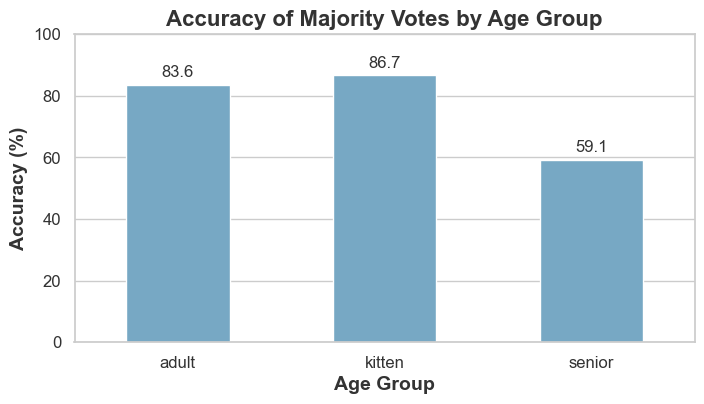

In [155]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [156]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          551            427  77.495463
1           kitten          114             95  83.333333
2           senior          178            119  66.853933


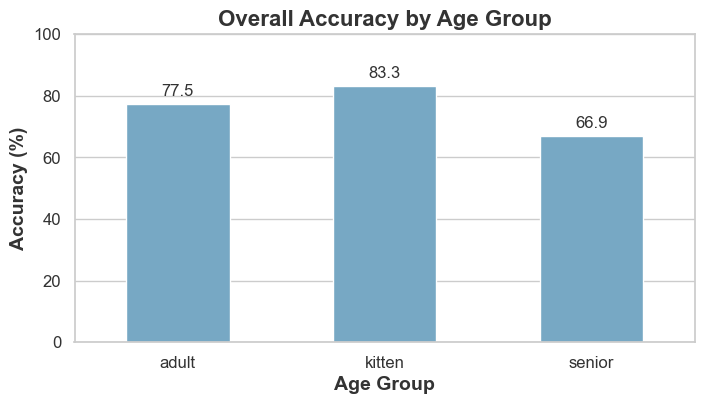

In [157]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')


## Gender Exploration

In [158]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    215      163     75.81
1          M    337      256     75.96
2          X    291      222     76.29


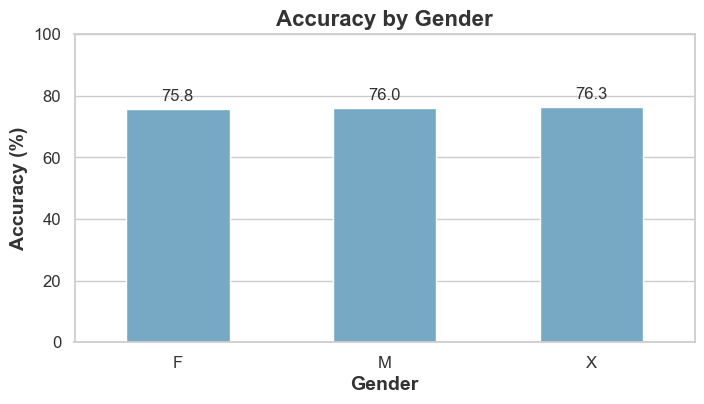

In [159]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# RANDOM SEED 5

In [160]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
dataframe.drop('mean_freq', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     588
senior    178
kitten    171
Name: age_group, dtype: int64


In [161]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [162]:
tf.keras.backend.clear_session()

## Run Setup

In [163]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import optuna

all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
000A    39
002B    32
047A    28
057A    27
074A    25
020A    23
055A    20
067A    19
029A    17
019A    17
097A    16
101A    15
059A    14
042A    14
106A    14
097B    14
028A    13
111A    13
051A    12
039A    12
116A    12
025A    11
036A    11
063A    11
068A    11
014B    10
016A    10
071A    10
005A    10
072A     9
051B     9
033A     9
045A     9
015A     9
013B     8
094A     8
095A     8
010A     8
050A     7
027A     7
031A     7
099A     7
117A     7
053A     6
008A     6
007A     6
037A     6
023A     6
025C     5
075A     5
021A     5
023B     5
070A     5
034A     5
062A     4
052A     4
003A     4
104A     4
105A     4
009A     4
035A     4
056A     3
014A     3
058A     3
060A     3
025B     2
102A     2
061A     2
069A     2
032A     2
093A     2
038A     2
087A     2
073A     1
090A     1
100A     1
110A     1
091A     1
041A     1
088A     1
048A     1
066A     1
076A     1
096A     1
026C     1
043A     1
024A     1



Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 153, Predictions: 153, Actuals: 153, Gender: 153
Final Test Results - Loss: 0.7172483801841736, Accuracy: 0.7189542651176453, Precision: 0.6281033500560487, Recall: 0.6854921898025346, F1 Score: 0.6258926774750673
Confusion Matrix:
 [[85  5 26]
 [ 7 17  0]
 [ 5  0  8]]
outer_fold 2
Train Set Group Distribution:
046A    63
103A    33
057A    27
074A    25
020A    23
055A    20
000B    19
029A    17
019A    17
097A    16
101A    15
059A    14
001A    14
097B    14
106A    14
028A    13
002A    13
111A    13
051A    12
025A    11
036A    11
005A    10
040A    10
071A    10
014B    10
022A     9
015A     9
065A     9
045A     9
072A     9
095A     8
094A     8
031A     7
027A     7
008A     6
108A     6
109A     6
053A     6
023A     6
037A     6
023B     5
070A     5
044A     5
021A     5
034A     5
052A     4
003A     4
105A     4
009A     4
026A     4
035A     4
104A     4
062A     4
064A   

Final Test Results - Loss: 0.8116528987884521, Accuracy: 0.7020407915115356, Precision: 0.7186952348242671, Recall: 0.5733567139592964, F1 Score: 0.6071805647511794
Confusion Matrix:
 [[133   1  19]
 [ 30  21   0]
 [ 23   0  18]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
020A    23
055A    20
000B    19
067A    19
019A    17
101A    15
059A    14
042A    14
097B    14
001A    14
002A    13
111A    13
116A    12
051A    12
039A    12
068A    11
036A    11
063A    11
014B    10
016A    10
040A    10
071A    10
065A     9
033A     9
051B     9
022A     9
010A     8
095A     8
013B     8
027A     7
099A     7
031A     7
050A     7
117A     7
007A     6
109A     6
108A     6
037A     6
008A     6
044A     5
025C     5
070A     5
075A     5
034A     5
023B     5
052A     4
026A     4
105A     4
060A     3
012A     3
064A     3
006A     3
113A     3
014A     3
061A     2
054A     2
087A     2
025B     2
011A     2
018A     2
102A     2
0

Majority Vote Accuracy for cat_id for this fold: 0.73 (22/30)
Before appending - Cat IDs: 398, Predictions: 398, Actuals: 398, Gender: 398
After appending - Cat IDs: 621, Predictions: 621, Actuals: 621, Gender: 621
Final Test Results - Loss: 0.9416781067848206, Accuracy: 0.6681614518165588, Precision: 0.6001009718540957, Recall: 0.7479065946219231, F1 Score: 0.6413456584920149
Confusion Matrix:
 [[101  10  26]
 [  0   9   0]
 [ 38   0  39]]
outer_fold 4
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
067A    19
000B    19
029A    17
097A    16
042A    14
001A    14
106A    14
028A    13
002A    13
039A    12
116A    12
025A    11
063A    11
068A    11
040A    10
005A    10
016A    10
051B     9
022A     9
045A     9
065A     9
072A     9
033A     9
015A     9
094A     8
010A     8
013B     8
117A     7
099A     7
050A     7
007A     6
053A     6
108A     6
109A     6
023A     6
021A     5
025C     5
044A     5
075A     5
009A  

## Majority Voting on Total Entries per cat_id 

In [164]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 849, Predictions: 849, Actuals: 849, Gender: 849


In [165]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [166]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

Overall Majority Vote Accuracy for cat_id: 0.74 (81/110)


In [167]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [168]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, kitten, kitten, senior, adult, adult, ...",adult,adult,True
81,075A,"[adult, adult, adult, adult, adult]",adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, senior, adult, senior]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, senior, senior, adult, s...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True


In [169]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     60
kitten     9
senior    12
Name: Majority_Correct, dtype: int64


In [170]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             60  82.191781
1           kitten           15              9  60.000000
2           senior           22             12  54.545455


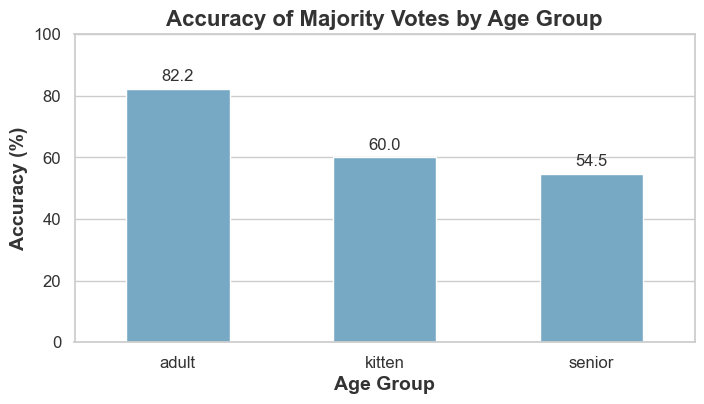

In [171]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [172]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          562            437  77.758007
1           kitten          109             70  64.220183
2           senior          178            100  56.179775


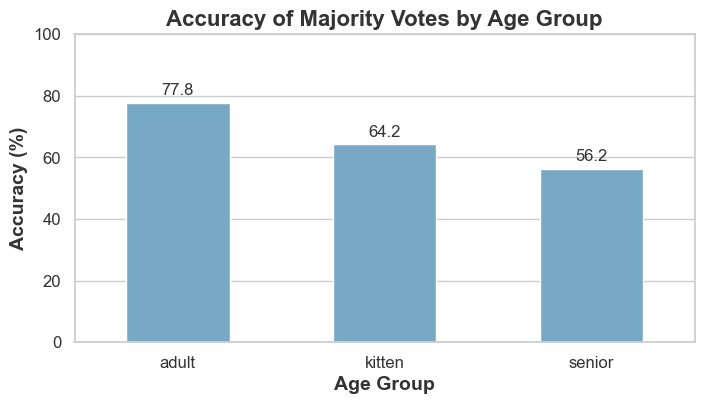

In [173]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [174]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    226      176     77.88
1          M    337      248     73.59
2          X    286      183     63.99


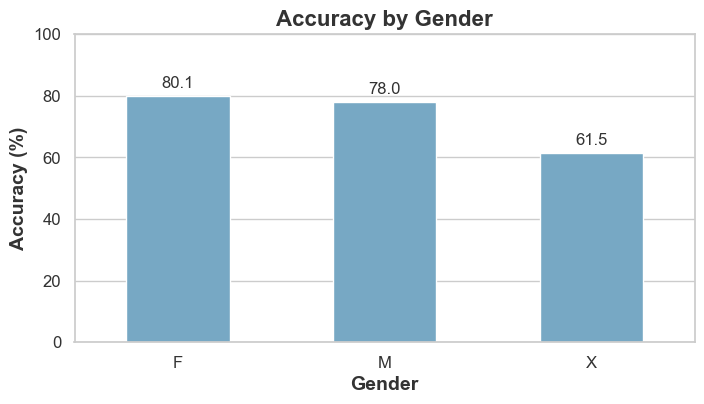

In [88]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')